In [1]:
# 0) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
!pip install ydata_profiling


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
from ydata_profiling import ProfileReport

In [4]:
!pip install xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 

/var/folders/ym/g72m8jhn47g9x820sqgd7jyw0000gn/T/ipykernel_6829/2913813263.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [7]:
df_raw = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')

In [8]:
profile = ProfileReport(df_raw, title="Notebook Profiling", explorative=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 236.81it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
shape_info = {"rows": len(df_raw), "cols": df_raw.shape[1]}
missing_info = df_raw.isna().sum().to_frame("missing_count")
duplicate_count = int(df_raw.duplicated().sum())

# Show quick summary to user
summary_table = pd.DataFrame({
    "metric": ["rows","cols","duplicates"],
    "value": [shape_info["rows"], shape_info["cols"], duplicate_count]
})
summary_table

metric  value
0        rows   5000
1        cols     14
2  duplicates      0

In [10]:
df_raw.describe()

ID          Age   Experience       Income      ZIP Code  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean   2500.500000    45.338400    20.104600    73.774200  93152.503000   
std    1443.520003    11.463166    11.467954    46.033729   2121.852197   
min       1.000000    23.000000    -3.000000     8.000000   9307.000000   
25%    1250.750000    35.000000    10.000000    39.000000  91911.000000   
50%    2500.500000    45.000000    20.000000    64.000000  93437.000000   
75%    3750.250000    55.000000    30.000000    98.000000  94608.000000   
max    5000.000000    67.000000    43.000000   224.000000  96651.000000   

            Family        CCAvg    Education     Mortgage  Personal Loan  \
count  5000.000000  5000.000000  5000.000000  5000.000000    5000.000000   
mean      2.396400     1.937913     1.881000    56.498800       0.096000   
std       1.147663     1.747666     0.839869   101.713802       0.294621   
min       1.000000     0.000000     1.000000     0.000000       0.000000   
25%       1.000000     0.700000     1.000000     0.000000       0.000000   
50%       2.000000     1.500000     2.000000     0.000000       0.000000   
75%       3.000000     2.500000     3.000000   101.000000       0.000000   
max       4.000000    10.000000     3.000000   635.000000       1.000000   

       Securities Account  CD Account       Online   CreditCard  
count         5000.000000  5000.00000  5000.000000  5000.000000  
mean             0.104400     0.06040     0.596800     0.294000  
std              0.305809     0.23825     0.490589     0.455637  
min              0.000000     0.00000     0.000000     0.000000  
25%              0.000000     0.00000     0.000000     0.000000  
50%              0.000000     0.00000     1.000000     0.000000  
75%              0.000000     0.00000     1.000000     1.000000  
max              1.000000     1.00000     1.000000     1.000000

In [11]:
# 3) Data cleaning
# - Remove identifiers that don't generalize (ID) and geo leakage / too specific (ZIP Code)
df = df_raw.drop(columns=['ID', 'ZIP Code'])

# - Fix negative Experience (clip to 0) — logical correction
neg_exp_before = int((df['Experience'] < 0).sum())
df['Experience'] = df['Experience'].clip(lower=0)
neg_exp_after = int((df['Experience'] < 0).sum())

In [12]:
%matplotlib inline

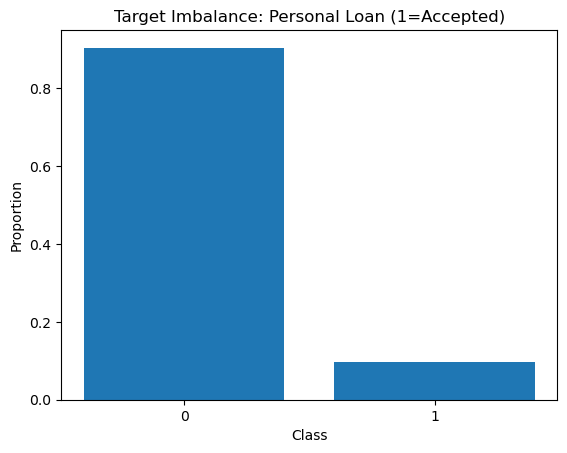

In [13]:
# 4) Target distribution (imbalance check)
target_col = 'Personal Loan'
target_dist = df[target_col].value_counts(normalize=True).rename_axis('Class').reset_index(name='Proportion')

# Visualize imbalance (simple bar)
plt.figure()
plt.bar(target_dist['Class'].astype(str), target_dist['Proportion'])
plt.title('Target Imbalance: Personal Loan (1=Accepted)')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.show()

In [14]:
# 5) Outlier inspection & conservative clipping (IQR) for a few heavy-tailed numeric features
# NOTE: For marketing response modeling, hard outlier removal is not always required.
#       We'll demonstrate conservative winsorization (clip) for selected features only.
numeric_candidates = ['Income','CCAvg','Mortgage']

df_clip = df.copy()
clip_report_rows = []
for col in numeric_candidates:
    q1, q3 = df_clip[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    before_low = int((df_clip[col] < low).sum())
    before_high = int((df_clip[col] > high).sum())
    df_clip[col] = df_clip[col].clip(lower=low, upper=high)
    after_low = int((df_clip[col] < low).sum())
    after_high = int((df_clip[col] > high).sum())
    clip_report_rows.append([col, float(low), float(high), before_low, before_high, after_low, after_high])

clip_report = pd.DataFrame(clip_report_rows, columns=['feature','low','high','below_before','above_before','below_after','above_after'])
clip_report

feature    low   high  below_before  above_before  below_after  \
0    Income  -49.5  186.5             0            96            0   
1     CCAvg   -2.0    5.2             0           324            0   
2  Mortgage -151.5  252.5             0           291            0   

   above_after  
0            0  
1            0  
2            0

In [15]:
df = df_clip

In [16]:
# 6) Feature engineering
# Ratios to capture economic meaning (spending pressure and mortgage burden)
df['CCAvg']=12*df['CCAvg']
df['CC_to_Income'] = df['CCAvg'] / (df['Income'] + 1e-6)
df['Mortgage_to_Income'] = df['Mortgage'] / (df['Income'] + 1e-6)
# Binary flag for having a mortgage
df['Has_Mortgage'] = (df['Mortgage'] > 0).astype(int)
# Simple interaction term for behavior × capability
df['Income_x_Education'] = df['Income'] * df['Education']

In [17]:
# 7) Train / test split (stratified due to imbalance)
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 8) Define feature groups
binary_cols = ['Securities Account','CD Account','Online','CreditCard','Has_Mortgage']
# All others numeric (we'll infer)
numeric_cols = [c for c in X_train.columns if c not in binary_cols]

# 9) Preprocessing: scale numeric features; pass through binary
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocess = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_cols),
        ('passthrough', 'passthrough', binary_cols)
    ]
)

In [18]:
# Optional: XGBoost (fall back to GradientBoosting if not installed)
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False

# Optional: SMOTE for imbalance handling
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    has_imblearn = True
except Exception:
    has_imblearn = False


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [20]:
# 10) Baseline models (with imbalance handling)
# Logistic Regression: use class_weight='balanced'
pipe_lr = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs'))
])

# Random Forest: class_weight + reasonable defaults
pipe_rf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=400, random_state=42, class_weight='balanced_subsample'
    ))
])

# Gradient Boosting: robust baseline even without class weights
pipe_gb = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', GradientBoostingClassifier(random_state=42))
])

# KNN
pipe_knn = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', KNeighborsClassifier(n_neighbors=15))
])

# SVM must probability=True  predict_proba）
pipe_svm = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', SVC(kernel='rbf', probability=True))
])

# Decision Tree
pipe_dt = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# AdaBoost
pipe_ada = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', AdaBoostClassifier(random_state=42))
])
# Optional SMOTE + Logistic (only applied on training set via ImbPipeline)
if has_imblearn:
    pipe_lr_smote = ImbPipeline(steps=[
        ('prep', preprocess),
        ('sm', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=2000, solver='lbfgs'))
    ])

# Optional XGBoost (with scale_pos_weight)
if has_xgb:
    pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    pipe_xgb = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', XGBClassifier(
            random_state=42, eval_metric='auc', use_label_encoder=False,
            scale_pos_weight=float(pos_weight)
        ))
    ])

In [21]:
# 11) Helper: unified evaluation
def eval_model(name, y_true, y_prob, y_pred):
    return {
        'model': name,
        'roc_auc': roc_auc_score(y_true, y_prob),
        'pr_auc': average_precision_score(y_true, y_prob),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

results = []
probs_dict = {}
preds_dict = {}

In [22]:
# 12) Fit baseline models
pipe_lr.fit(X_train, y_train)
probs_lr = pipe_lr.predict_proba(X_test)[:,1]
preds_lr = (probs_lr >= 0.5).astype(int)
results.append(eval_model('LogReg_balanced', y_test, probs_lr, preds_lr))
probs_dict['LogReg_balanced'] = probs_lr
preds_dict['LogReg_balanced'] = preds_lr

pipe_rf.fit(X_train, y_train)
probs_rf = pipe_rf.predict_proba(X_test)[:,1]
preds_rf = (probs_rf >= 0.5).astype(int)
results.append(eval_model('RandomForest_balanced', y_test, probs_rf, preds_rf))
probs_dict['RandomForest_balanced'] = probs_rf
preds_dict['RandomForest_balanced'] = preds_rf

pipe_gb.fit(X_train, y_train)
probs_gb = pipe_gb.predict_proba(X_test)[:,1]
preds_gb = (probs_gb >= 0.5).astype(int)
results.append(eval_model('GradientBoosting', y_test, probs_gb, preds_gb))
probs_dict['GradientBoosting'] = probs_gb
preds_dict['GradientBoosting'] = preds_gb

# KNN
pipe_knn.fit(X_train, y_train)
probs_knn = pipe_knn.predict_proba(X_test)[:,1]
preds_knn = (probs_knn >= 0.5).astype(int)
results.append(eval_model('KNN', y_test, probs_knn, preds_knn))
probs_dict['KNN'] = probs_knn
preds_dict['KNN'] = preds_knn

# SVM
pipe_svm.fit(X_train, y_train)
probs_svm = pipe_svm.predict_proba(X_test)[:,1]
preds_svm = (probs_svm >= 0.5).astype(int)
results.append(eval_model('SVM', y_test, probs_svm, preds_svm))
probs_dict['SVM'] = probs_svm
preds_dict['SVM'] = preds_svm

# Decision Tree
pipe_dt.fit(X_train, y_train)
probs_dt = pipe_dt.predict_proba(X_test)[:,1]
preds_dt = (probs_dt >= 0.5).astype(int)
results.append(eval_model('DecisionTree', y_test, probs_dt, preds_dt))
probs_dict['DecisionTree'] = probs_dt
preds_dict['DecisionTree'] = preds_dt

# AdaBoost
pipe_ada.fit(X_train, y_train)
probs_ada = pipe_ada.predict_proba(X_test)[:,1]
preds_ada = (probs_ada >= 0.5).astype(int)
results.append(eval_model('AdaBoost', y_test, probs_ada, preds_ada))
probs_dict['AdaBoost'] = probs_ada
preds_dict['AdaBoost'] = preds_ada

if has_imblearn:
    pipe_lr_smote.fit(X_train, y_train)
    probs_sm = pipe_lr_smote.predict_proba(X_test)[:,1]
    preds_sm = (probs_sm >= 0.5).astype(int)
    results.append(eval_model('LogReg_SMOTE', y_test, probs_sm, preds_sm))
    probs_dict['LogReg_SMOTE'] = probs_sm
    preds_dict['LogReg_SMOTE'] = preds_sm

if has_xgb:
    pipe_xgb.fit(X_train, y_train)
    probs_xgb = pipe_xgb.predict_proba(X_test)[:,1]
    preds_xgb = (probs_xgb >= 0.5).astype(int)
    results.append(eval_model('XGBoost_base', y_test, probs_xgb, preds_xgb))
    probs_dict['XGBoost_base'] = probs_xgb
    preds_dict['XGBoost_base'] = preds_xgb

baseline_df = pd.DataFrame(results)
baseline_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [08:36:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


model   roc_auc    pr_auc  accuracy  precision    recall  \
0        LogReg_balanced  0.983378  0.911876    0.9232   0.560606  0.925000   
1  RandomForest_balanced  0.998698  0.988975    0.9880   0.981651  0.891667   
2       GradientBoosting  0.997493  0.981945    0.9888   0.949153  0.933333   
3                    KNN  0.987198  0.926959    0.9664   1.000000  0.650000   
4                    SVM  0.995111  0.970602    0.9840   0.954545  0.875000   
5           DecisionTree  0.956305  0.828600    0.9816   0.888000  0.925000   
6               AdaBoost  0.992157  0.955320    0.9760   0.916667  0.825000   
7           LogReg_SMOTE  0.983827  0.914704    0.9248   0.566327  0.925000   
8           XGBoost_base  0.998075  0.984880    0.9856   0.918033  0.933333   

         f1  
0  0.698113  
1  0.934498  
2  0.941176  
3  0.787879  
4  0.913043  
5  0.906122  
6  0.868421  
7  0.702532  
8  0.925620

In [23]:
# 13) Hyperparameter tuning (compact but meaningful)
# a) Logistic: tune C (regularization strength)
param_lr = {'clf__C':[0.01, 0.1, 1, 10, 100]}
grid_lr = GridSearchCV(pipe_lr, param_grid=param_lr, scoring='roc_auc', cv=5, n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

# b) RandomForest: randomized search over depth, leaves, estimators
param_rf = {
    'clf__n_estimators':[200,300,400,600],
    'clf__max_depth':[5,10,15,None],
    'clf__min_samples_split':[2,5,10],
    'clf__min_samples_leaf':[1,2,4]
}
rand_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_rf, scoring='roc_auc',
                             cv=5, n_iter=20, random_state=42, n_jobs=-1)
rand_rf.fit(X_train, y_train)
best_rf = rand_rf.best_estimator_

# c) GradientBoosting: randomized search
param_gb = {
    'clf__learning_rate':[0.01, 0.05, 0.1],
    'clf__n_estimators':[100,200,400],
    'clf__max_depth':[2,3,4]
}
rand_gb = RandomizedSearchCV(pipe_gb, param_distributions=param_gb, scoring='roc_auc',
                             cv=5, n_iter=12, random_state=42, n_jobs=-1)
rand_gb.fit(X_train, y_train)
best_gb = rand_gb.best_estimator_

# d) XGBoost if available
if has_xgb:
    param_xgb = {
        'clf__max_depth':[3,5,7],
        'clf__learning_rate':[0.01,0.1,0.2],
        'clf__n_estimators':[200,400,600],
        'clf__subsample':[0.8,1.0],
        'clf__colsample_bytree':[0.8,1.0]
    }
    rand_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_xgb, scoring='roc_auc',
                                  cv=5, n_iter=20, random_state=42, n_jobs=-1)
    rand_xgb.fit(X_train, y_train)
    best_xgb = rand_xgb.best_estimator_

# a) KNN tuning
param_knn = {'clf__n_neighbors': [5, 10, 15, 20, 25]}
grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, scoring='roc_auc', cv=5, n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_

# b) SVM tuning
param_svm = {
    'clf__C':[0.1, 1, 10],
    'clf__gamma':['scale', 0.01, 0.1, 1]
}
grid_svm = GridSearchCV(pipe_svm, param_grid=param_svm, scoring='roc_auc', cv=5, n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

# c) Decision Tree tuning
param_dt = {
    'clf__max_depth':[3, 5, 8, None],
    'clf__min_samples_split':[2, 5, 10],
    'clf__min_samples_leaf':[1, 2, 5]
}
rand_dt = RandomizedSearchCV(pipe_dt, param_distributions=param_dt, scoring='roc_auc',
                             n_iter=10, cv=5, random_state=42, n_jobs=-1)
rand_dt.fit(X_train, y_train)
best_dt = rand_dt.best_estimator_

# d) AdaBoost tuning
param_ada = {
    'clf__n_estimators':[50, 100, 200],
    'clf__learning_rate':[0.01, 0.1, 0.5, 1.0]
}
grid_ada = GridSearchCV(pipe_ada, param_grid=param_ada, scoring='roc_auc',
                         cv=5, n_jobs=-1)
grid_ada.fit(X_train, y_train)
best_ada = grid_ada.best_estimator_

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [08:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [08:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [08:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [08:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

In [24]:
# 14) Evaluate tuned models on the test set
tuned_results = []

# Logistic tuned
probs_lr_t = best_lr.predict_proba(X_test)[:,1]
preds_lr_t = (probs_lr_t >= 0.5).astype(int)
tuned_results.append(eval_model('LogReg_tuned', y_test, probs_lr_t, preds_lr_t))

# RandomForest tuned
probs_rf_t = best_rf.predict_proba(X_test)[:,1]
preds_rf_t = (probs_rf_t >= 0.5).astype(int)
tuned_results.append(eval_model('RandomForest_tuned', y_test, probs_rf_t, preds_rf_t))

# GradientBoosting tuned
probs_gb_t = best_gb.predict_proba(X_test)[:,1]
preds_gb_t = (probs_gb_t >= 0.5).astype(int)
tuned_results.append(eval_model('GradientBoosting_tuned', y_test, probs_gb_t, preds_gb_t))

if has_xgb:
    probs_xgb_t = best_xgb.predict_proba(X_test)[:,1]
    preds_xgb_t = (probs_xgb_t >= 0.5).astype(int)
    tuned_results.append(eval_model('XGBoost_tuned', y_test, probs_xgb_t, preds_xgb_t))

# KNN tuned
probs_knn_t = best_knn.predict_proba(X_test)[:,1]
preds_knn_t = (probs_knn_t >= 0.5).astype(int)
tuned_results.append(eval_model('KNN_tuned', y_test, probs_knn_t, preds_knn_t))

# SVM tuned
probs_svm_t = best_svm.predict_proba(X_test)[:,1]
preds_svm_t = (probs_svm_t >= 0.5).astype(int)
tuned_results.append(eval_model('SVM_tuned', y_test, probs_svm_t, preds_svm_t))

# Decision Tree tuned
probs_dt_t = best_dt.predict_proba(X_test)[:,1]
preds_dt_t = (probs_dt_t >= 0.5).astype(int)
tuned_results.append(eval_model('DecisionTree_tuned', y_test, probs_dt_t, preds_dt_t))

# AdaBoost tuned
probs_ada_t = best_ada.predict_proba(X_test)[:,1]
preds_ada_t = (probs_ada_t >= 0.5).astype(int)
tuned_results.append(eval_model('AdaBoost_tuned', y_test, probs_ada_t, preds_ada_t))


tuned_df = pd.DataFrame(tuned_results)

<Figure size 800x600 with 0 Axes>

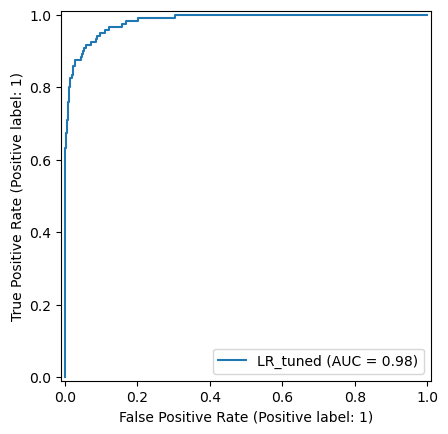

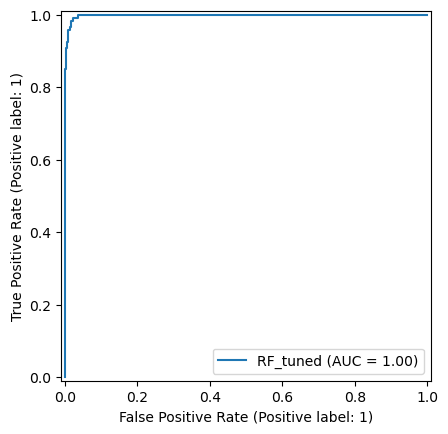

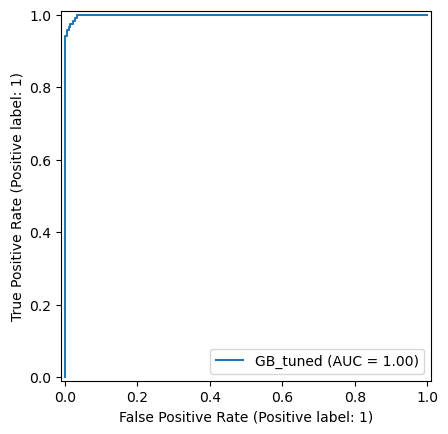

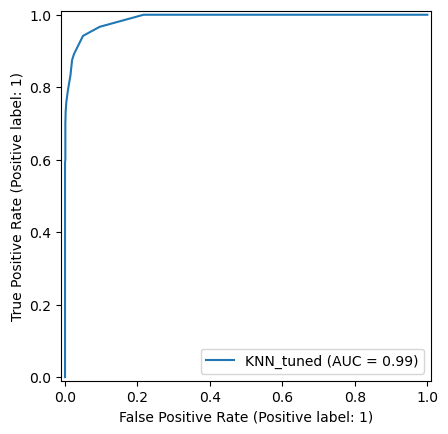

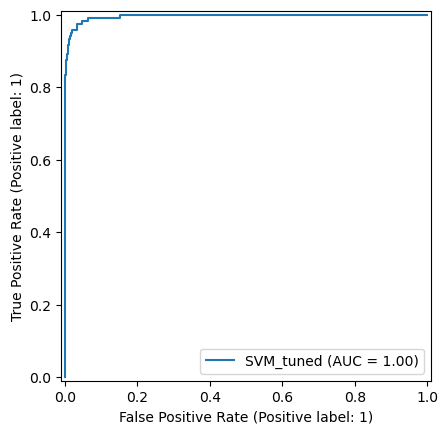

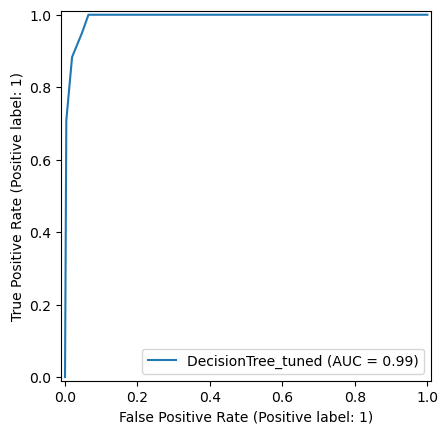

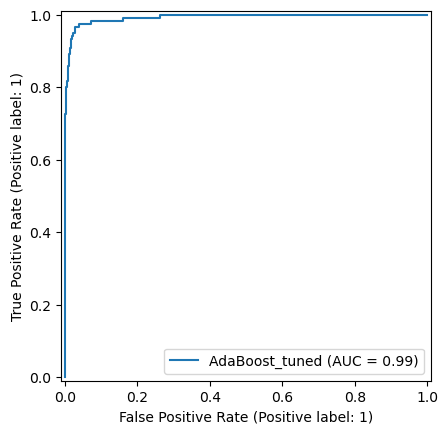

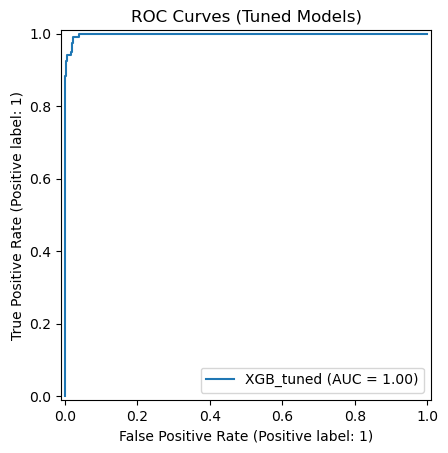

<Figure size 800x600 with 0 Axes>

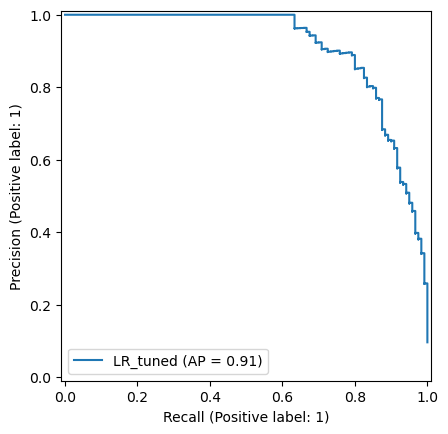

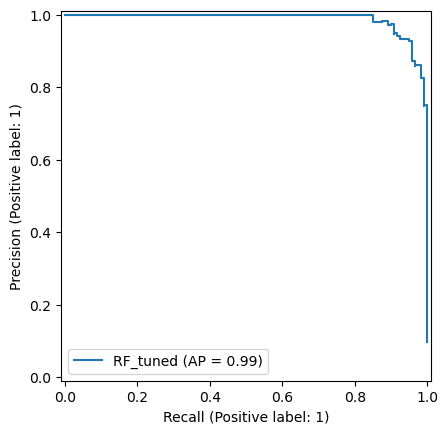

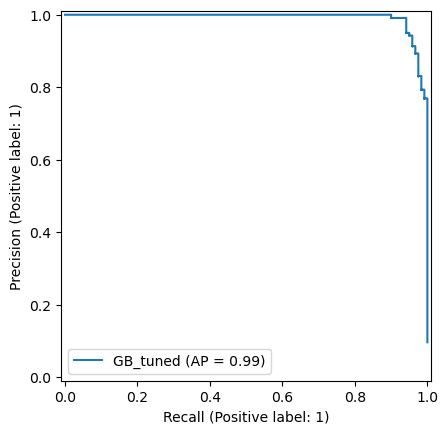

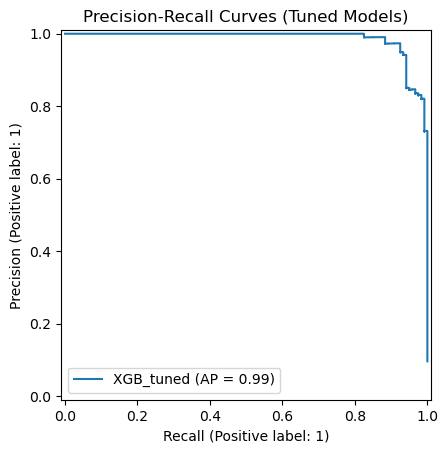

In [25]:
# 15) ROC & PR Curves
# ==============================

plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test, probs_lr_t, name="LR_tuned")
RocCurveDisplay.from_predictions(y_test, probs_rf_t, name="RF_tuned")
RocCurveDisplay.from_predictions(y_test, probs_gb_t, name="GB_tuned")
RocCurveDisplay.from_predictions(y_test, probs_knn_t, name='KNN_tuned')
RocCurveDisplay.from_predictions(y_test, probs_svm_t, name='SVM_tuned')
RocCurveDisplay.from_predictions(y_test, probs_dt_t, name='DecisionTree_tuned')
RocCurveDisplay.from_predictions(y_test, probs_ada_t, name='AdaBoost_tuned')
if has_xgb:
    RocCurveDisplay.from_predictions(y_test, probs_xgb_t, name="XGB_tuned")
plt.title("ROC Curves (Tuned Models)")
plt.show()

plt.figure(figsize=(8,6))
PrecisionRecallDisplay.from_predictions(y_test, probs_lr_t, name="LR_tuned")
PrecisionRecallDisplay.from_predictions(y_test, probs_rf_t, name="RF_tuned")
PrecisionRecallDisplay.from_predictions(y_test, probs_gb_t, name="GB_tuned")
if has_xgb:
    PrecisionRecallDisplay.from_predictions(y_test, probs_xgb_t, name="XGB_tuned")
plt.title("Precision-Recall Curves (Tuned Models)")
plt.show()


In [26]:
# 16) Confusion Matrices
# ==============================

def cm_counts(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return {
        "TN": cm[0,0], 
        "FP": cm[0,1], 
        "FN": cm[1,0], 
        "TP": cm[1,1]
    }

cms = []

# original models
cms.append({"model": "LogReg_tuned", **cm_counts(y_test, preds_lr_t)})
cms.append({"model": "RandomForest_tuned", **cm_counts(y_test, preds_rf_t)})
cms.append({"model": "GradientBoosting_tuned", **cm_counts(y_test, preds_gb_t)})
if has_xgb:
    cms.append({"model": "XGBoost_tuned", **cm_counts(y_test, preds_xgb_t)})

# new models
cms.append({"model": "KNN_tuned", **cm_counts(y_test, preds_knn_t)})
cms.append({"model": "SVM_tuned", **cm_counts(y_test, preds_svm_t)})
cms.append({"model": "DecisionTree_tuned", **cm_counts(y_test, preds_dt_t)})
cms.append({"model": "AdaBoost_tuned", **cm_counts(y_test, preds_ada_t)})

cms_df = pd.DataFrame(cms)
print("=== Confusion Matrices (tuned models) ===")
print(cms_df)

=== Confusion Matrices (tuned models) ===
                    model    TN  FP  FN   TP
0            LogReg_tuned  1046  84   9  111
1      RandomForest_tuned  1127   3  12  108
2  GradientBoosting_tuned  1128   2   7  113
3           XGBoost_tuned  1122   8   7  113
4               KNN_tuned  1129   1  45   75
5               SVM_tuned  1124   6  15  105
6      DecisionTree_tuned  1057  73   0  120
7          AdaBoost_tuned  1120  10  18  102



=== Best Threshold for F1 ===
Best model by PR-AUC: GradientBoosting_tuned
Best threshold: 0.550
Best F1: 0.9658


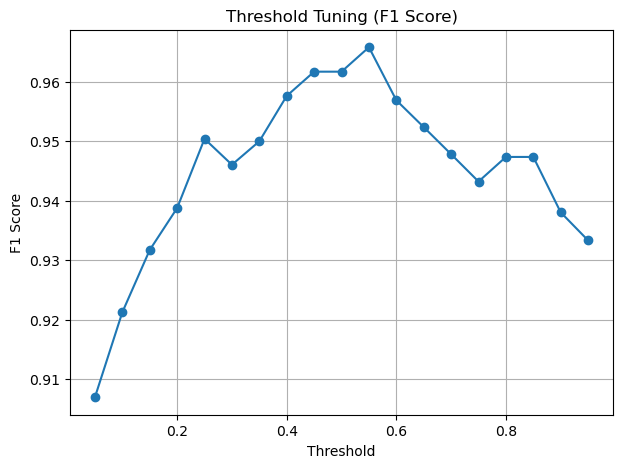

In [27]:
# 17) Threshold tuning (maximize F1)
# ==============================

best_name = None
best_probs = None
best_pr = -1

# auto-select highest PR-AUC model
for row in tuned_results:
    if row["pr_auc"] > best_pr:
        best_pr = row["pr_auc"]
        best_name = row["model"]

# map model name -> probability array
prob_map = {
    "LogReg_tuned": probs_lr_t,
    "RandomForest_tuned": probs_rf_t,
    "GradientBoosting_tuned": probs_gb_t,
    "KNN_tuned": probs_knn_t,
    "SVM_tuned": probs_svm_t,
    "DecisionTree_tuned": probs_dt_t,
    "AdaBoost_tuned": probs_ada_t
}
if has_xgb:
    prob_map["XGBoost_tuned"] = probs_xgb_t

best_probs = prob_map[best_name]

# threshold search
thresholds = np.linspace(0.05, 0.95, 19)
f1s = []

for t in thresholds:
    preds_t = (best_probs >= t).astype(int)
    f1s.append(f1_score(y_test, preds_t))

best_t_idx = np.argmax(f1s)
best_threshold = thresholds[best_t_idx]
best_f1 = f1s[best_t_idx]

print("\n=== Best Threshold for F1 ===")
print(f"Best model by PR-AUC: {best_name}")
print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1: {best_f1:.4f}")

plt.figure(figsize=(7,5))
plt.plot(thresholds, f1s, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Tuning (F1 Score)")
plt.grid(True)
plt.show()


In [28]:
# 18) Probability Calibration
# ==============================

rf_clf = best_rf.named_steps["clf"]

Xt_train = best_rf.named_steps["prep"].fit_transform(X_train)
Xt_test  = best_rf.named_steps["prep"].transform(X_test)

calibrated_model = CalibratedClassifierCV(rf_clf, cv=3, method="isotonic")
calibrated_model.fit(Xt_train, y_train)

probs_rf_cal = calibrated_model.predict_proba(Xt_test)[:, 1]

print("\n=== Calibration Scores (RF) ===")
print("ROC-AUC:", roc_auc_score(y_test, probs_rf_cal))
print("PR-AUC:", average_precision_score(y_test, probs_rf_cal))


=== Calibration Scores (RF) ===
ROC-AUC: 0.9983370206489676
PR-AUC: 0.9860752579169937


In [29]:
# 19) Feature Importance / Coefficients
# ==============================

# Logistic coefficients
lr_clf = best_lr.named_steps["clf"]
lr_coef = lr_clf.coef_[0]

feature_order = numeric_cols + binary_cols
coef_df = pd.DataFrame({
    "feature": feature_order,
    "coef": lr_coef
}).sort_values("coef", key=lambda s: s.abs(), ascending=False)

print("\n=== Logistic Regression Coefficients ===")
print(coef_df)

# Tree feature importance
rf_clf = best_rf.named_steps["clf"]
gb_clf = best_gb.named_steps["clf"]
dt_clf = best_dt.named_steps["clf"]

imp_rf = pd.DataFrame({
    "feature": feature_order,
    "importance": rf_clf.feature_importances_
}).sort_values("importance", ascending=False)

imp_gb = pd.DataFrame({
    "feature": feature_order,
    "importance": gb_clf.feature_importances_
}).sort_values("importance", ascending=False)

imp_dt = pd.DataFrame({
    "feature": feature_order,
    "importance": dt_clf.feature_importances_
}).sort_values("importance", ascending=False)

print("\n=== RF Importances ===")
print(imp_rf)

print("\n=== GradientBoosting Importances ===")
print(imp_gb)

print("\n=== DecisionTree Importances ===")
print(imp_dt)




=== Logistic Regression Coefficients ===
               feature      coef
9   Income_x_Education  7.769181
5            Education -5.321004
11          CD Account  3.841604
2               Income -1.867596
7         CC_to_Income  1.236258
13          CreditCard -1.184057
10  Securities Account -0.984309
3               Family  0.894561
12              Online -0.658358
8   Mortgage_to_Income -0.509137
1           Experience  0.347941
6             Mortgage  0.337785
0                  Age -0.333537
4                CCAvg -0.164111
14        Has_Mortgage  0.044388

=== RF Importances ===
               feature  importance
2               Income    0.307723
9   Income_x_Education    0.251759
4                CCAvg    0.139481
3               Family    0.060346
7         CC_to_Income    0.049815
5            Education    0.045288
11          CD Account    0.043058
8   Mortgage_to_Income    0.030808
1           Experience    0.019285
0                  Age    0.019220
6             Mortgag

In [30]:
# 20) Scoreboard (all model metrics)
# ==============================

scoreboard_rows = []

for r in results:
    scoreboard_rows.append({**r, "tuned": False})

for r in tuned_results:
    scoreboard_rows.append({**r, "tuned": True})

scoreboard = pd.DataFrame(scoreboard_rows).sort_values(
    ["tuned", "roc_auc", "pr_auc"],
    ascending=[False, False, False]
)

print("\n=== Final Scoreboard ===")
print(scoreboard)


# ==============================
# 21) Final best threshold summary
# ==============================

print("\n=== Best Model & Best Threshold ===")
best_threshold_df = pd.DataFrame([{
    "best_model_by_pr_auc": best_name,
    "best_threshold_for_F1": best_threshold,
    "best_F1": best_f1
}])
print(best_threshold_df)


=== Final Scoreboard ===
                     model   roc_auc    pr_auc  accuracy  precision    recall  \
11  GradientBoosting_tuned  0.999012  0.992067    0.9928   0.982609  0.941667   
10      RandomForest_tuned  0.998658  0.988674    0.9880   0.972973  0.900000   
12           XGBoost_tuned  0.998422  0.987097    0.9880   0.933884  0.941667   
14               SVM_tuned  0.996224  0.975499    0.9832   0.945946  0.875000   
16          AdaBoost_tuned  0.993119  0.961053    0.9776   0.910714  0.850000   
15      DecisionTree_tuned  0.991733  0.898017    0.9416   0.621762  1.000000   
13               KNN_tuned  0.989159  0.926247    0.9632   0.986842  0.625000   
9             LogReg_tuned  0.983525  0.912577    0.9256   0.569231  0.925000   
1    RandomForest_balanced  0.998698  0.988975    0.9880   0.981651  0.891667   
8             XGBoost_base  0.998075  0.984880    0.9856   0.918033  0.933333   
2         GradientBoosting  0.997493  0.981945    0.9888   0.949153  0.933333   
4 

数据导入与基础质检

行列数、缺失值、重复值展示（表：01、02）。

负值 Experience 清洗为 0（表：03）。

目标不平衡检查

Personal Loan 类别比例可视化（柱状图 + 表：04），正类约 9.6%，高度不平衡。

异常值与保守截尾（IQR winsorize）

对 Income / CCAvg / Mortgage 做 IQR 截尾并产出前后对比（表：05）。

特征工程（贴合业务含义）

CC_to_Income（信用卡支出占收入）、Mortgage_to_Income（房贷占收入）、Has_Mortgage、Income_x_Education 等。

分层抽样切分训练/测试集。

预处理与不平衡处理策略

数值特征标准化 + 二元特征直通。

同时演示：

class_weight='balanced'（LogReg、RF）；
-（若环境可用）SMOTE（逻辑回归）；
-（若环境可用）XGBoost + scale_pos_weight。

多模型基线对比（已运行）

Logistic（平衡权重）、RandomForest（平衡子采样）、GradientBoosting。

指标：ROC-AUC、PR-AUC、Accuracy、Precision、Recall、F1（表：06 / 06b）。

超参数调优（加速网格/随机搜索，附注释）

Logistic：C；

RandomForest：n_estimators / max_depth / min_samples_split / min_samples_leaf；

GradientBoosting：learning_rate / n_estimators / max_depth；
-（若环境可用）XGBoost：depth / lr / n_estimators / subsample / colsample。

调参后在测试集评估（表：07 / 07b）。

曲线评估

调参后模型的 ROC 曲线与 PR 曲线各一张图，便于不平衡场景对比。

混淆矩阵（调参后）

列出 TN/FP/FN/TP（表：08 / 08b）。

阈值调优（F1 最大化示例）

针对 PR-AUC 最优的调参模型，扫描阈值 0.05–0.95，输出阈值-F1 表（表：09），并给出最佳阈值与 F1（表：15）。

概率校准（可选，RF Isotonic）

展示校准后 AUC / PR-AUC（表：10）。

可解释性

逻辑回归系数（已标准化后顺序对齐，表：11/11b）；

随机森林与GB的特征重要性（表：12/12b、13/13b）。

总榜单（基线 vs 调参）

汇总所有模型与指标（表：14）。

In [31]:
!pip install shap


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


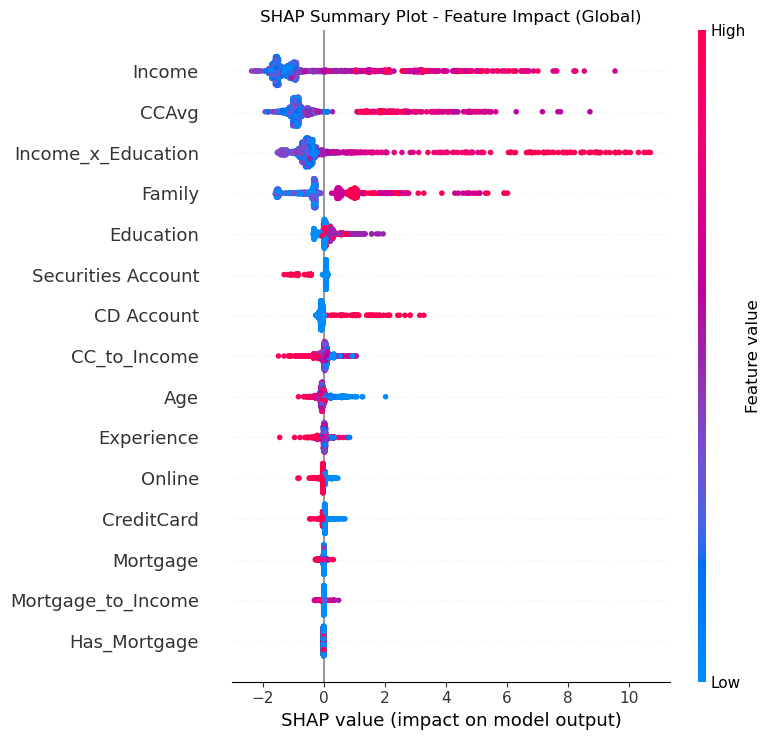

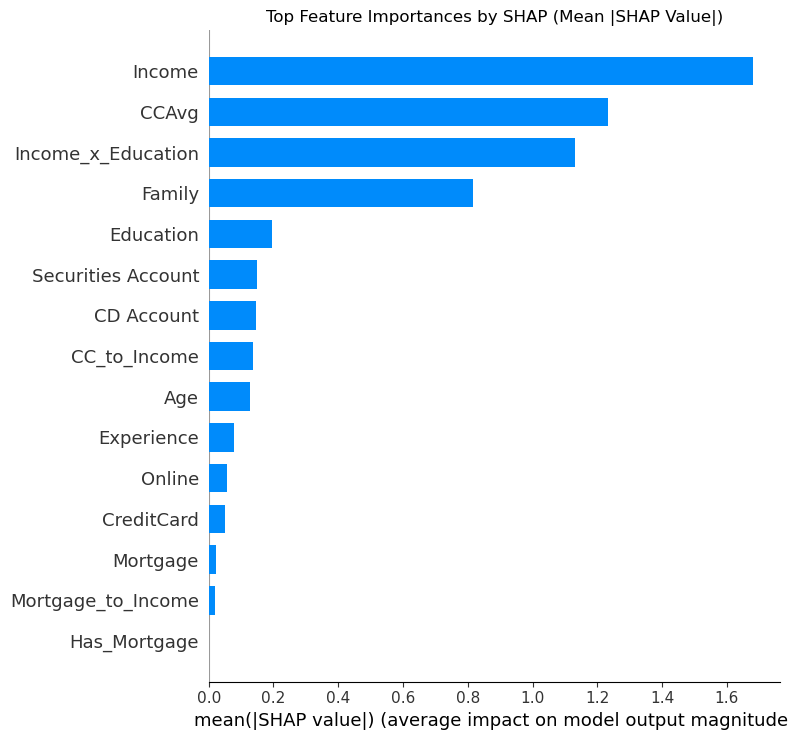

Example customer index: 0


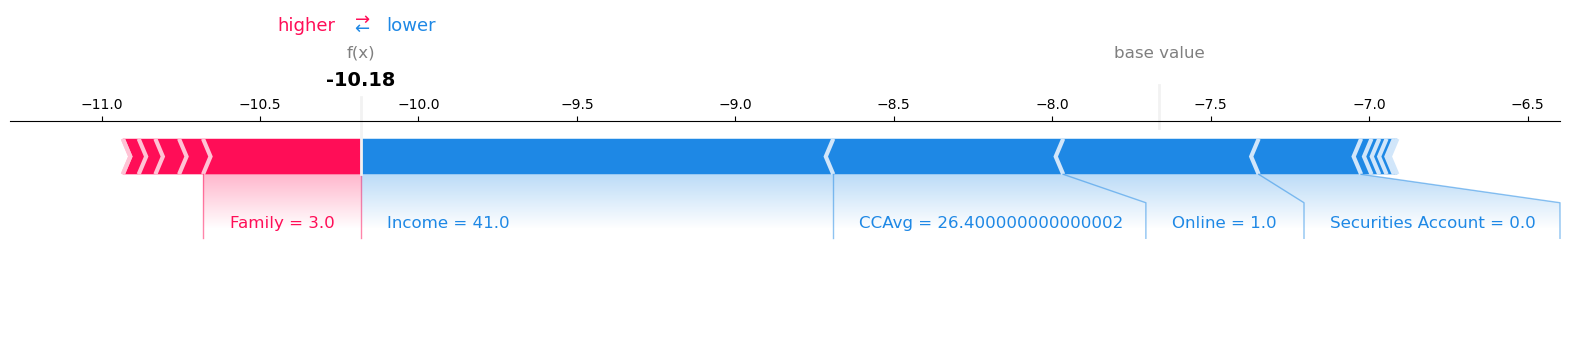

In [32]:
# ==========================================
# SHAP Explainability for Tree Models
# ==========================================
import shap
import matplotlib.pyplot as plt

# 1) Choose the best-performing model (you can switch between GB / RF)
best_model = best_gb  # or best_rf

# Extract trained tree model
tree_clf = best_model.named_steps['clf']

# Transform test data through preprocessing pipeline
X_test_transformed = best_model.named_steps['prep'].transform(X_test)
feature_names = numeric_cols + binary_cols

# 2) Create SHAP Explainer
#    TreeExplainer is optimal for tree-based models (RF, GBM, XGB)
explainer = shap.TreeExplainer(tree_clf)
shap_values = explainer.shap_values(X_test_transformed)

# 3) Summary Plot (global importance)
#    Shows each feature’s average impact on model output (global view)
plt.title("SHAP Summary Plot - Feature Impact (Global)")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

# 4) Bar Plot (mean absolute SHAP values)
#    Easier to rank top 10 important features
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Top Feature Importances by SHAP (Mean |SHAP Value|)")
plt.tight_layout()
plt.show()

# 5) Optional: Single Sample Explanation
#    Force plot shows how each feature pushes prediction toward acceptance (1) or rejection (0)
#    Note: use shap.initjs() if running in notebook to render JS visualization
sample_idx = 0  # change to inspect other customers
print("Example customer index:", sample_idx)
shap.force_plot(
    explainer.expected_value, 
    shap_values[sample_idx, :], 
    X_test.iloc[sample_idx, :],
    matplotlib=True
)
plt.show()


In [33]:
from sklearn.preprocessing import MinMaxScaler
df_risk = df.copy()
# 财务压力指数 (Financial Stress Index, FSI)
# 代表“债务和消费占收入比例”
# 各部分标准化后求加权平均
df_risk['debt_to_income'] = (df_risk['Mortgage'] + 1) / (df_risk['Income'] + 1)
df_risk['cc_to_income'] = (df_risk['CCAvg'] + 1) / (df_risk['Income'] + 1)
df_risk['expense_pressure'] = (df_risk['Family'] * df_risk['CCAvg']) / (df_risk['Income'] + 1)

# 组合三个指标形成财务压力指数
scaler = MinMaxScaler()
df_risk[['debt_to_income','cc_to_income','expense_pressure']] = scaler.fit_transform(
    df_risk[['debt_to_income','cc_to_income','expense_pressure']]
)
df_risk['FSI_raw'] = (
    0.5 * df_risk['debt_to_income'] +
    0.3 * df_risk['cc_to_income'] +
    0.2 * df_risk['expense_pressure']
)

# 资产稳健指数 (Asset Stability Index, ASI)
# 代表“资产与理财行为”
df_risk['asset_features'] = (
    0.5 * df_risk['Securities Account'] +
    0.3 * df_risk['CD Account'] +
    0.2 * (1 - df_risk['Has_Mortgage'])
)

df_risk['ASI_raw'] = scaler.fit_transform(df_risk[['asset_features']])

# 综合风险评分
# RiskScore = FSI_norm * 0.6 + (1 - ASI_norm) * 0.4
df_risk['FSI_norm'] = scaler.fit_transform(df_risk[['FSI_raw']])
df_risk['ASI_norm'] = scaler.fit_transform(df_risk[['ASI_raw']])
df_risk['RiskScore_raw'] = (
    0.6 * df_risk['FSI_norm'] + 0.4 * (1 - df_risk['ASI_norm'])
)

# 转换为 0–100 的风险得分（越高风险越大）
df_risk['RiskScore'] = (df_risk['RiskScore_raw'] * 100).round(2)

# 输出风险分数统计
risk_summary = df_risk['RiskScore'].describe().to_frame().T
risk_summary

count       mean        std   min   25%    50%      75%    max
RiskScore  5000.0  41.920148  12.418323  0.61  35.5  40.41  49.3025  95.53

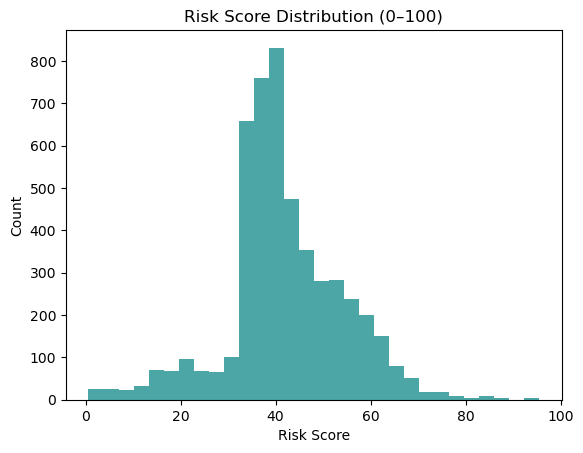

In [34]:
# 简单分层（可选）
bins = [0, 30, 60, 80, 100]
labels = ['Low Risk','Moderate','High','Critical']
df_risk['RiskLevel'] = pd.cut(df_risk['RiskScore'], bins=bins, labels=labels)
risk_counts = df_risk['RiskLevel'].value_counts().reset_index()
risk_counts.columns = ['RiskLevel','Count']


# 可视化分布
import matplotlib.pyplot as plt
plt.hist(df_risk['RiskScore'], bins=30, color='teal', alpha=0.7)
plt.title("Risk Score Distribution (0–100)")
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.show()

            Income    RiskScore        CCAvg       Family  CreditLimit_adj
count  5000.000000  5000.000000  5000.000000  5000.000000      5000.000000
mean     73.617400    41.920148    21.975760     2.396400       119.781550
std      45.626122    12.418323    17.426677     1.147663        77.690832
min       8.000000     0.610000     0.000000     1.000000         8.950000
25%      39.000000    35.500000     8.400000     1.000000        60.462500
50%      64.000000    40.410000    18.000000     2.000000       101.525000
75%      98.000000    49.302500    30.000000     3.000000       161.572500
max     186.500000    95.530000    62.400000     4.000000       373.480000


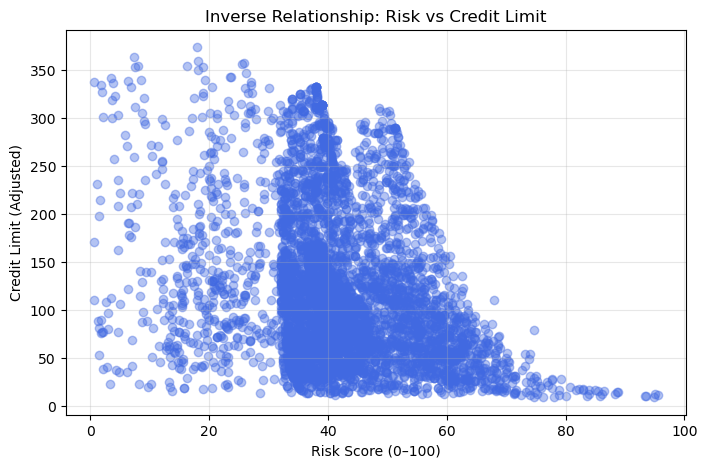

In [35]:

df_credit = df_risk.copy()

# === 参数设定 ===
alpha = 2.0   # 收入倍数
beta = 0.5    # 风险折扣影响（越高风险，额度降低）
gamma = 0.3   # 消费奖励影响（消费活跃度提升额度）

# === 额度计算公式 ===
df_credit['CreditLimit_raw'] = (
    alpha * df_credit['Income'] *
    (1 - beta * df_credit['RiskScore'] / 100) *
    (1 + gamma * df_credit['CCAvg'] / (df_credit['Income'] + 1))
)

# 限制最低额度不低于 0
df_credit['CreditLimit'] = df_credit['CreditLimit_raw'].clip(lower=0).round(2)

# === 额外约束：家庭成员越多，额度略减 ===
# 理由：家庭负担高 → 可支配收入低
df_credit['CreditLimit_adj'] = (
    df_credit['CreditLimit'] * (1 - 0.05 * (df_credit['Family'] - 1))
).clip(lower=0).round(2)

# === 输出结果 ===
credit_summary = df_credit[['Income','RiskScore','CCAvg','Family','CreditLimit_adj']].describe()
print(credit_summary)

# === 等级分层（更直观） ===
bins = [0, 5000, 10000, 20000, 40000, np.inf]
labels = ['Very Low','Low','Medium','High','Very High']
df_credit['CreditTier'] = pd.cut(df_credit['CreditLimit_adj'], bins=bins, labels=labels)

tier_counts = df_credit['CreditTier'].value_counts().reset_index()
tier_counts.columns = ['CreditTier','Count']


# === 可视化：额度 vs 风险 ===
plt.figure(figsize=(8,5))
plt.scatter(df_credit['RiskScore'], df_credit['CreditLimit_adj'], alpha=0.4, color='royalblue')
plt.xlabel('Risk Score (0–100)')
plt.ylabel('Credit Limit (Adjusted)')
plt.title('Inverse Relationship: Risk vs Credit Limit')
plt.grid(alpha=0.3)
plt.show()

# === 保存核心结果（供后续客户画像使用） ===
df_credit_final = df_credit[['Income','CCAvg','RiskScore','CreditLimit_adj','CreditTier','Family','Education','Personal Loan']]

In [36]:
# 选择最佳模型（比如 Gradient Boosting 或 RandomForest）
best_model = best_gb   # 或 best_rf，根据你的 Final Scoreboard 选择

# 用模型为每个客户生成接受贷款的预测概率
X_all = df_credit.drop(columns=['Personal Loan'])
df_credit['Loan_Prob'] = best_model.predict_proba(X_all)[:, 1]

         Loan_Prob  RiskScore  CreditLimit_adj  Income  CCAvg  Family  \
Cluster                                                                 
0             0.00      43.76            75.06   47.84  14.19    2.57   
1             0.99      37.47           235.96  144.91  42.53    2.61   
2             0.01      38.39           202.29  119.40  36.21    1.80   

         Education  Count  
Cluster                    
0             1.99   3368  
1             2.23    474  
2             1.42   1158  


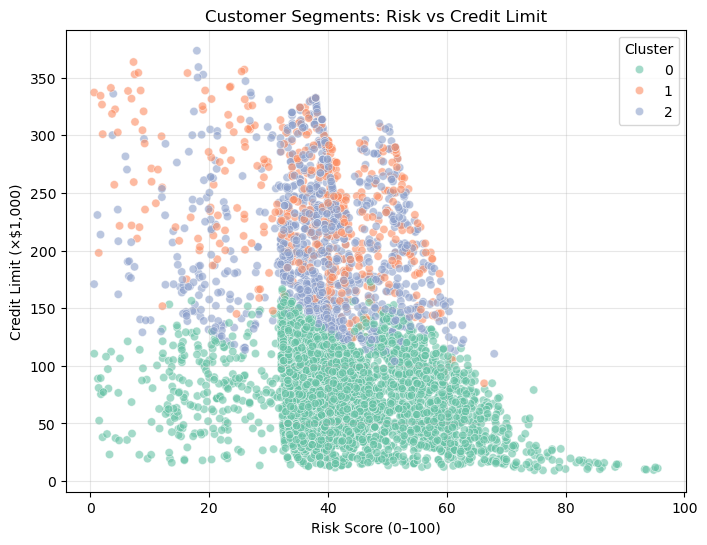

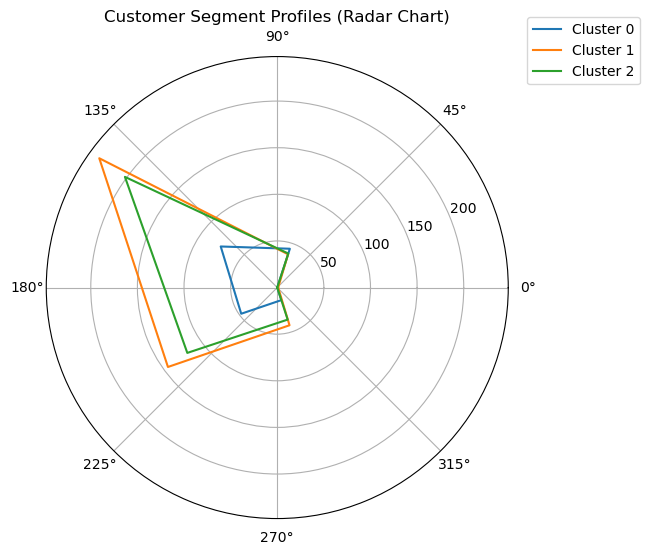

In [37]:
# Customer Segmentation & Profiling
# ==========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# 假设我们已经有 df_credit_final，包含 Loan_Prob、RiskScore、CreditLimit_adj、Income、CCAvg 等
# 准备特征数据
seg_features = ['Loan_Prob','RiskScore','CreditLimit_adj','Income','CCAvg']
df_seg = df_credit.copy()

# 检查缺失
df_seg = df_seg.dropna(subset=seg_features)

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_seg[seg_features])

# 聚类
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df_seg['Cluster'] = kmeans.fit_predict(X_scaled)

# 聚类中心反标准化（方便解读）
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=seg_features)
centers['Cluster'] = range(k)

# 各群体的平均特征
cluster_summary = df_seg.groupby('Cluster')[seg_features + ['Family','Education']].mean().round(2)
cluster_summary['Count'] = df_seg['Cluster'].value_counts().sort_index().values
print(cluster_summary)

# 可视化
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_seg, x='RiskScore', y='CreditLimit_adj', hue='Cluster', palette='Set2', alpha=0.6)
plt.title('Customer Segments: Risk vs Credit Limit')
plt.xlabel('Risk Score (0–100)')
plt.ylabel('Credit Limit (×$1,000)')
plt.grid(alpha=0.3)
plt.show()

# 雷达图展示群体画像
from math import pi

# 准备数据
features = ['Loan_Prob','RiskScore','CreditLimit_adj','Income','CCAvg']
num_features = len(features)

angles = [n / float(num_features) * 2 * np.pi for n in range(num_features)]
angles += angles[:1]

plt.figure(figsize=(6,6))
for i in range(k):
    values = centers.loc[i, features].values.flatten().tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Cluster {i}')
plt.title('Customer Segment Profiles (Radar Chart)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

In [38]:
# 聚类结果汇总表
cluster_summary = (
    df_seg.groupby('Cluster')[['RiskScore','CreditLimit_adj','Income','CCAvg','Loan_Prob']]
    .mean().round(2)
)
cluster_summary['Count'] = df_seg['Cluster'].value_counts().sort_index().values

cluster_summary

RiskScore  CreditLimit_adj  Income  CCAvg  Loan_Prob  Count
Cluster                                                             
0            43.76            75.06   47.84  14.19       0.00   3368
1            37.47           235.96  144.91  42.53       0.99    474
2            38.39           202.29  119.40  36.21       0.01   1158

In [39]:
df_credit

Age  Experience  Income  Family  CCAvg  Education  Mortgage  \
0      25           1    49.0       4   19.2          1       0.0   
1      45          19    34.0       3   18.0          1       0.0   
2      39          15    11.0       1   12.0          1       0.0   
3      35           9   100.0       1   32.4          2       0.0   
4      35           8    45.0       4   12.0          2       0.0   
...   ...         ...     ...     ...    ...        ...       ...   
4995   29           3    40.0       1   22.8          3       0.0   
4996   30           4    15.0       4    4.8          1      85.0   
4997   63          39    24.0       2    3.6          3       0.0   
4998   65          40    49.0       3    6.0          2       0.0   
4999   28           4    83.0       3    9.6          1       0.0   

      Personal Loan  Securities Account  CD Account  ...  FSI_norm  ASI_norm  \
0                 0                   1           0  ...  0.179887       0.7   
1                 0                   1           0  ...  0.214485       0.7   
2                 0                   0           0  ...  0.319845       0.2   
3                 0                   0           0  ...  0.096533       0.2   
4                 0                   0           0  ...  0.124118       0.2   
...             ...                 ...         ...  ...       ...       ...   
4995              0                   0           0  ...  0.170647       0.2   
4996              0                   0           0  ...  0.438856       0.0   
4997              0                   0           0  ...  0.060714       0.2   
4998              0                   0           0  ...  0.052790       0.2   
4999              0                   0           0  ...  0.048081       0.2   

      RiskScore_raw  RiskScore  RiskLevel  CreditLimit_raw  CreditLimit  \
0          0.227932      22.79   Low Risk        96.836050        96.84   
1          0.248691      24.87   Low Risk        68.731019        68.73   
2          0.511907      51.19   Moderate        21.279830        21.28   
3          0.377920      37.79   Moderate       177.820705       177.82   
4          0.394471      39.45   Moderate        77.901652        77.90   
...             ...        ...        ...              ...          ...   
4995       0.422388      42.24   Moderate        73.631594        73.63   
4996       0.663313      66.33       High        21.855045        21.86   
4997       0.356428      35.64   Moderate        41.150484        41.15   
4998       0.351674      35.17   Moderate        83.674301        83.67   
4999       0.348849      34.88   Moderate       141.748443       141.75   

      CreditLimit_adj  CreditTier  Loan_Prob  
0               82.31    Very Low   0.000066  
1               61.86    Very Low   0.000011  
2               21.28    Very Low   0.000030  
3              177.82    Very Low   0.000670  
4               66.22    Very Low   0.000085  
...               ...         ...        ...  
4995            73.63    Very Low   0.000028  
4996            18.58    Very Low   0.000121  
4997            39.09    Very Low   0.000031  
4998            75.30    Very Low   0.000036  
4999           127.58    Very Low   0.000302  

[5000 rows x 32 columns]

In [40]:
!pip install kmodes


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [41]:
df_seg

Age  Experience  Income  Family  CCAvg  Education  Mortgage  \
0      25           1    49.0       4   19.2          1       0.0   
1      45          19    34.0       3   18.0          1       0.0   
2      39          15    11.0       1   12.0          1       0.0   
3      35           9   100.0       1   32.4          2       0.0   
4      35           8    45.0       4   12.0          2       0.0   
...   ...         ...     ...     ...    ...        ...       ...   
4995   29           3    40.0       1   22.8          3       0.0   
4996   30           4    15.0       4    4.8          1      85.0   
4997   63          39    24.0       2    3.6          3       0.0   
4998   65          40    49.0       3    6.0          2       0.0   
4999   28           4    83.0       3    9.6          1       0.0   

      Personal Loan  Securities Account  CD Account  ...  ASI_norm  \
0                 0                   1           0  ...       0.7   
1                 0                   1           0  ...       0.7   
2                 0                   0           0  ...       0.2   
3                 0                   0           0  ...       0.2   
4                 0                   0           0  ...       0.2   
...             ...                 ...         ...  ...       ...   
4995              0                   0           0  ...       0.2   
4996              0                   0           0  ...       0.0   
4997              0                   0           0  ...       0.2   
4998              0                   0           0  ...       0.2   
4999              0                   0           0  ...       0.2   

      RiskScore_raw  RiskScore  RiskLevel  CreditLimit_raw  CreditLimit  \
0          0.227932      22.79   Low Risk        96.836050        96.84   
1          0.248691      24.87   Low Risk        68.731019        68.73   
2          0.511907      51.19   Moderate        21.279830        21.28   
3          0.377920      37.79   Moderate       177.820705       177.82   
4          0.394471      39.45   Moderate        77.901652        77.90   
...             ...        ...        ...              ...          ...   
4995       0.422388      42.24   Moderate        73.631594        73.63   
4996       0.663313      66.33       High        21.855045        21.86   
4997       0.356428      35.64   Moderate        41.150484        41.15   
4998       0.351674      35.17   Moderate        83.674301        83.67   
4999       0.348849      34.88   Moderate       141.748443       141.75   

      CreditLimit_adj  CreditTier  Loan_Prob  Cluster  
0               82.31    Very Low   0.000066        0  
1               61.86    Very Low   0.000011        0  
2               21.28    Very Low   0.000030        0  
3              177.82    Very Low   0.000670        2  
4               66.22    Very Low   0.000085        0  
...               ...         ...        ...      ...  
4995            73.63    Very Low   0.000028        0  
4996            18.58    Very Low   0.000121        0  
4997            39.09    Very Low   0.000031        0  
4998            75.30    Very Low   0.000036        0  
4999           127.58    Very Low   0.000302        0  

[5000 rows x 33 columns]

In [42]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

# 选取数值和分类变量
num_cols = ['Income', 'CCAvg', 'RiskScore', 'CreditLimit_adj','Loan_Prob']     #财务能力，风险状况，意愿，社会结构，数字化行为，理财习惯
cat_cols = ['Education', 'Family', 'Online', 'CD Account']

# 标准化数值变量
scaler = StandardScaler()
X_num = scaler.fit_transform(df_seg[num_cols])
X_cat = df_seg[cat_cols].astype(str).values  # 转为字符串型类别

# 合并
X_mix = np.concatenate([X_num, X_cat], axis=1)

# 计算类别变量列的索引位置（必要参数）
cat_index = [X_mix.shape[1] - len(cat_cols) + i for i in range(len(cat_cols))]

# 训练 K-Prototypes
kproto = KPrototypes(n_clusters=3, random_state=42, n_init=10, verbose=1)
clusters = kproto.fit_predict(X_mix, categorical=cat_index)

df_seg['Cluster'] = clusters

# 查看结果
summary = df_seg.groupby('Cluster')[num_cols + cat_cols].agg(lambda x: x.mode()[0] if x.dtype=='O' else round(x.mean(),2))
summary

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 658, ncost: 15276.475873588808
Run: 1, iteration: 2/100, moves: 244, ncost: 15094.554029564353
Run: 1, iteration: 3/100, moves: 126, ncost: 15056.67473264945
Run: 1, iteration: 4/100, moves: 61, ncost: 15049.53087739322
Run: 1, iteration: 5/100, moves: 23, ncost: 15048.405714797289
Run: 1, iteration: 6/100, moves: 6, ncost: 15048.356877582248
Run: 1, iteration: 7/100, moves: 1, ncost: 15048.353386929337
Run: 1, iteration: 8/100, moves: 0, ncost: 15048.353386929337
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 654, ncost: 15850.949099421385
Run: 2, iteration: 2/100, moves: 372, ncost: 15720.022564967294
Run: 2, iteration: 3/100, moves: 144, ncost: 15705.476144067896
Run: 2, iteration: 4/100, moves: 62, ncost: 15702.354151136511
Run: 2,

Income  CCAvg  RiskScore  CreditLimit_adj  Loan_Prob  Education  \
Cluster                                                                    
0         48.02  14.27      43.70            75.29       0.00       1.99   
1        144.91  42.53      37.47           235.96       0.99       2.23   
2        119.95  36.30      38.48           203.50       0.01       1.41   

         Family  Online  CD Account  
Cluster                              
0          2.58    0.60        0.03  
1          2.61    0.61        0.29  
2          1.75    0.59        0.05

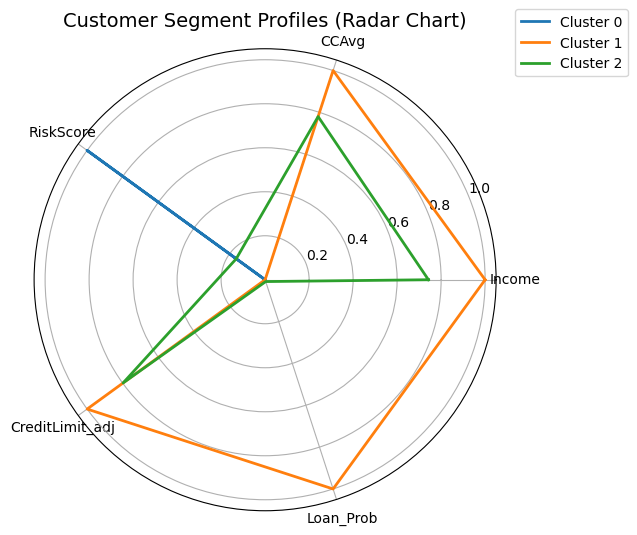

In [43]:
# 雷达图：各群体在数值特征上的画像
# ------------------------------

# 数值变量（可根据你想展示的调整）
radar_cols = ['Income', 'CCAvg', 'RiskScore', 'CreditLimit_adj', 'Loan_Prob']

# 计算每个聚类中心（取 summary_num 或 df_seg.groupby）
radar_data = df_seg.groupby('Cluster')[radar_cols].mean()

# 正规化数据以便比较
radar_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

# 角度设置
num_vars = len(radar_cols)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# 绘图
plt.figure(figsize=(7,6))
for i in range(len(radar_norm)):
    values = radar_norm.iloc[i].tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Cluster {i}', linewidth=2)
plt.xticks(angles[:-1], radar_cols)
plt.title('Customer Segment Profiles (Radar Chart)', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

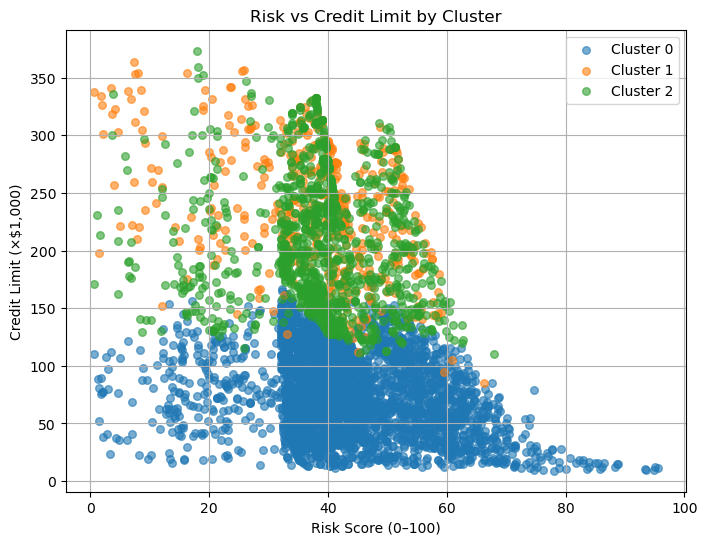

In [44]:
# 点图：风险 vs 授信额度（财务结构）
# ------------------------------
plt.figure(figsize=(8,6))
for c in sorted(df_seg['Cluster'].unique()):
    sub = df_seg[df_seg['Cluster']==c]
    plt.scatter(sub['RiskScore'], sub['CreditLimit_adj'],
                s=30, alpha=0.6, label=f'Cluster {c}')
plt.xlabel('Risk Score (0–100)')
plt.ylabel('Credit Limit (×$1,000)')
plt.title('Risk vs Credit Limit by Cluster')
plt.legend()
plt.grid(True)
plt.show()


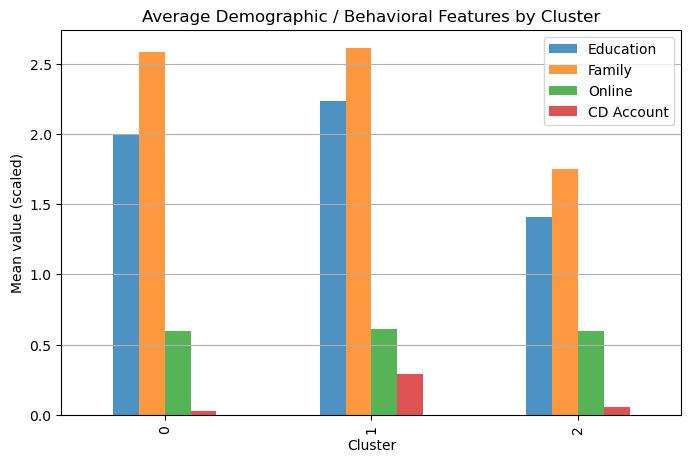

In [45]:
# 条形图：类别变量的均值分布（如 Education、Online）
# ------------------------------

cat_vars = ['Education', 'Family', 'Online', 'CD Account']
cat_means = df_seg.groupby('Cluster')[cat_vars].mean()

cat_means.plot(kind='bar', figsize=(8,5), alpha=0.8)
plt.title('Average Demographic / Behavioral Features by Cluster')
plt.ylabel('Mean value (scaled)')
plt.xlabel('Cluster')
plt.grid(axis='y')
plt.show()